In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5
series = baseline + trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


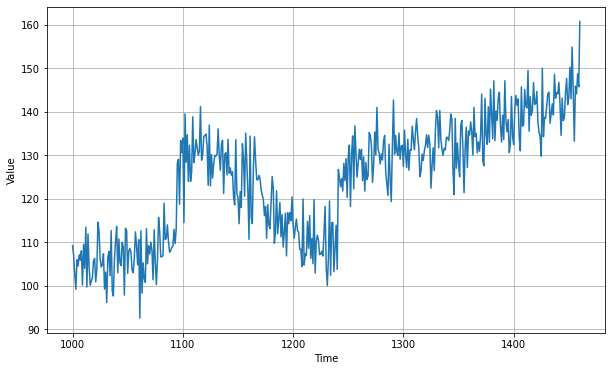

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[ 93.663025   103.19536     89.66095     94.539314    99.27729
  105.27643     97.177895    94.78875    107.0289      90.44167
   86.7466      99.99983     95.34888     92.81262    101.52045
   99.25781     95.278786    91.758286   102.582954   101.532776  ]
 [ 69.10134     74.36482     60.502842    76.68438     68.31821
   67.04559     64.19138     61.049683    73.51203     69.83512
   63.09121     63.138268    68.00752     78.10447     68.53446
   62.389908    68.75025     68.68882     56.641605    69.928314  ]
 [ 79.66659     76.12891     69.226036    65.11237     83.58645
   71.090515    70.93898     70.82374     72.00993     70.37297
   68.301865    68.51139     71.15755     68.679924    67.90868
   72.081055    70.350105    79.22116     58.52267     77.31149   ]
 [  6.5424857   17.89475      3.665866    13.40683     21.225418
    5.124302     7.05268     10.1930275    6.9914975    1.5732553
    9.490746     3.661521    11.169931     4.0376825   16.221285
    4.396209 

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                          activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [12]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(
lr=1e-6,
momentum=0.9))

c:\users\jleus\pycharmprojects\pythonproject1\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 1188.9381
Epoch 2/100
31/31 [==============================] - 0s 638us/step - loss: 80.2669
Epoch 3/100
31/31 [==============================] - 0s 675us/step - loss: 42.2437
Epoch 4/100
31/31 [==============================] - 0s 520us/step - loss: 41.5028
Epoch 5/100
31/31 [==============================] - 0s 533us/step - loss: 41.3792
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 40.8020
Epoch 7/100
31/31 [==============================] - 0s 800us/step - loss: 40.4819

In [14]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [16]:
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))

106.258606
[[103.11705]]


In [18]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [19]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

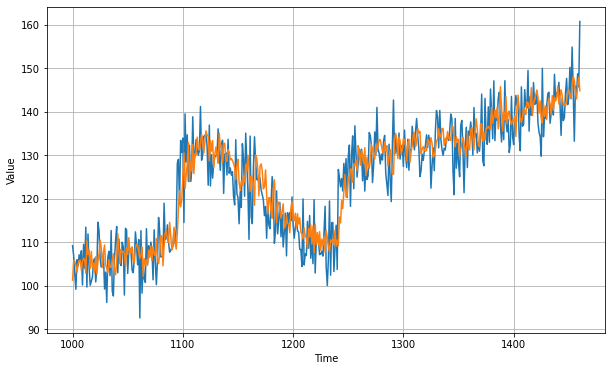

In [20]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7342286

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8 * 10**(epoch / 20))

In [23]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,
callbacks=[lr_schedule], verbose=0)

c:\users\jleus\pycharmprojects\pythonproject1\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


(1e-08, 0.001, 0.0, 300.0)

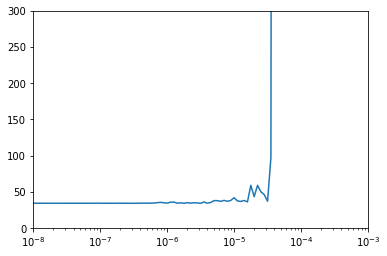

In [24]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [26]:
import keras_tuner

In [28]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size]))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5))
  return model

In [29]:
tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2),
activation='relu', input_shape=[window_size])


NameError: name 'hp' is not defined